In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import plotly.graph_objects as go
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import scipy.stats as st

In [3]:
# Step 1
def g0(x0):
    """g0(x0) = sin(x0)"""
    return np.sin(x0)

def g1(x0, x1):
    """g1(x0, x1) = x0 * x1"""
    return x0 * x1

def g2(x, y, r):
    """
    g2(x, y, r):
      returns x if r > 0,
      returns y if r < 0,
      returns 0 if r == 0 (rare for continuous r)
    """
    return np.where(r > 0, x, np.where(r < 0, y, 0))

def g3(x0, x1):
    """g3(x0, x1) = x0 + x1"""
    return x0 + x1

# Define a composed function F that uses all gi
def F(x0, x1, x2, x3):
    return g3(g2(g0(x0), g1(x1, x2), x3),x2)

In [4]:
# 1. Generate a DataFrame of random samples
n = 2000
df = pd.DataFrame({
    'x0': np.random.uniform(-np.pi, np.pi, n),
    'x1': np.random.uniform(-1, 1,     n),
    'x2': np.random.uniform(-2, 2,     n),
    'x3': np.random.uniform(-1, 1,     n),
})
df['F'] = F(df['x0'], df['x1'], df['x2'], df['x3'])


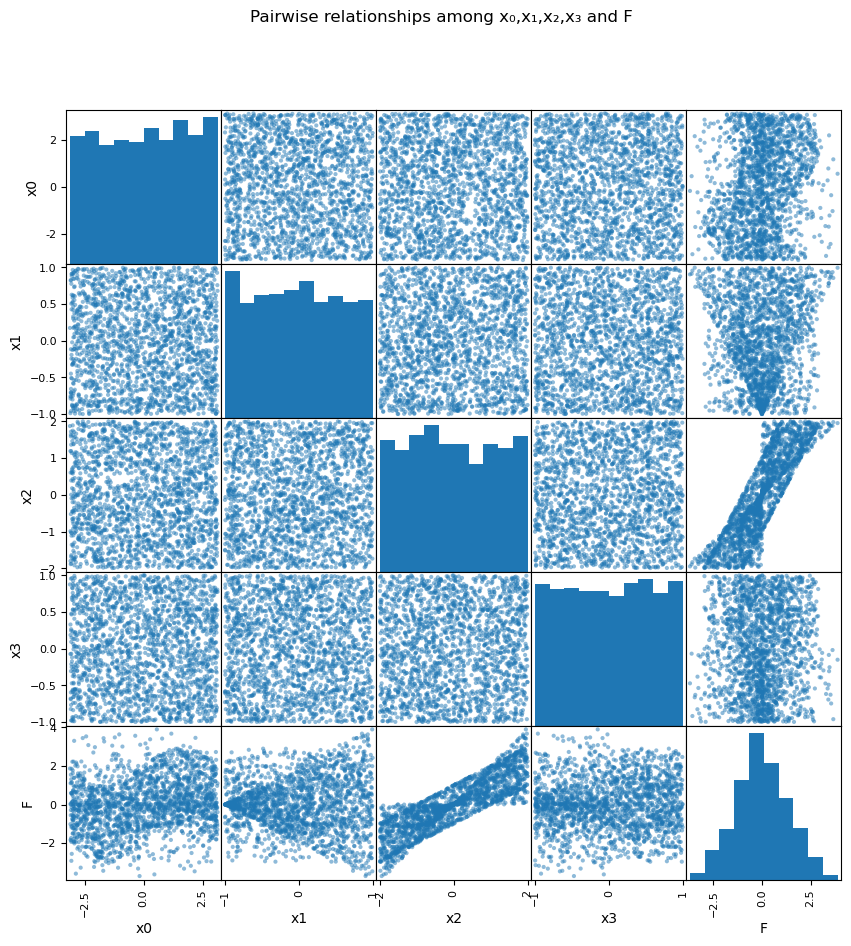

In [5]:
# Pairwise scatter‐matrix
scatter_matrix(df, figsize=(10,10), diagonal='hist')
plt.suptitle('Pairwise relationships among x₀,x₁,x₂,x₃ and F')
plt.show()


In [6]:
fig = px.scatter_matrix(
    df,
    dimensions=['x0','x1','x2','x3'],
    color='F',
    color_continuous_scale='Spectral',
    title='Interactive scatter-matrix of inputs, coloured by F'
)
fig.update_traces(diagonal_visible=False)  # or .update_diag()
fig.show()

In [7]:
# 1. Define OOD splits by distance-tail measure 
# Avoid exploiting that the training and test distributions are approximately inverse of each other.


# Compute distance to the *second* nearest neighbour
coords = df[['x0','x1','x2','x3']].values
nbrs = NearestNeighbors(n_neighbors=2).fit(coords)
distances, _ = nbrs.kneighbors(coords)

# distances[:,0] is always 0 (self-distance),
# so use distances[:,1] for the true nearest‐other distance:
df['dist'] = distances[:,1]

# Compute the relevant percentiles
p85, p90, p95 = np.percentile(df['dist'], [85, 90, 95])

# Define the masks exactly as before
mask_95_100 = df['dist'] >= p95
mask_90_95  = (df['dist'] >= p90) & (df['dist'] <  p95)
mask_85_90  = (df['dist'] >= p85) & (df['dist'] <  p90)

# Label splits
df['split'] = np.select(
    [mask_95_100, mask_90_95, mask_85_90],
    ['OOD_95_100','OOD_90_95','OOD_85_90'],
    default='train'
)


By carving out the farthest‐away points in your 4-D input space, you force your learner to extrapolate into regions well outside the manifold it saw during training. That makes the test truly “out-of-distribution” in two key ways:

It doesn’t artificially pick axis-aligned “holes” or spherical caps, but finds the most isolated points in full 4-D.

It thus simulates worst-case OOD: locations your model is least familiar with.


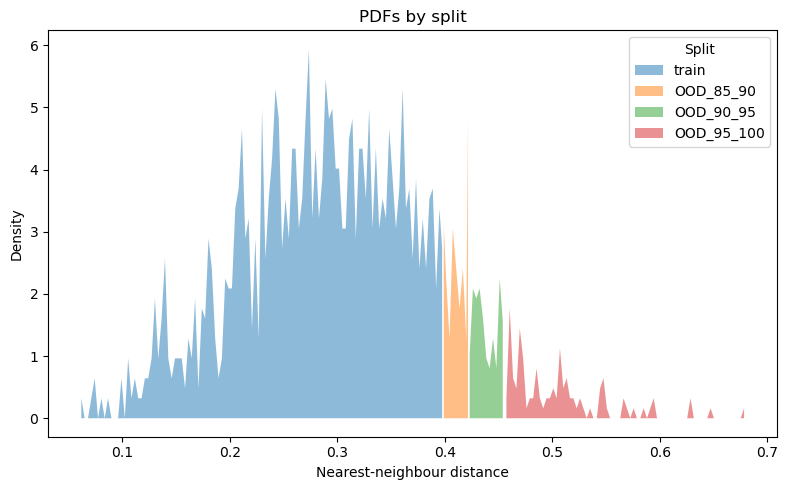

In [10]:
dist_all = df['dist']
global_edges = np.unique(np.concatenate([
    np.linspace(dist_all.min(), dist_all.max(), 200),
    [p85, p90, p95]
]))
centers = 0.5*(global_edges[:-1] + global_edges[1:])

plt.figure(figsize=(8,5))
for split_name in ['train','OOD_85_90','OOD_90_95','OOD_95_100']:
    d = df.loc[df['split']==split_name, 'dist'].values
    hist, _ = np.histogram(d, bins=global_edges, density=True)
    # scale density by fraction of points in this split
    hist_scaled = hist * (len(d) / len(df))
    # mask outside support
    mask = (centers >= d.min()) & (centers <= d.max())
    plt.fill_between(centers[mask], hist_scaled[mask], alpha=0.5, label=split_name)

plt.xlabel('Nearest-neighbour distance')
plt.ylabel('Density')
plt.title('PDFs by split')
plt.legend(title='Split')
plt.tight_layout()
plt.show()

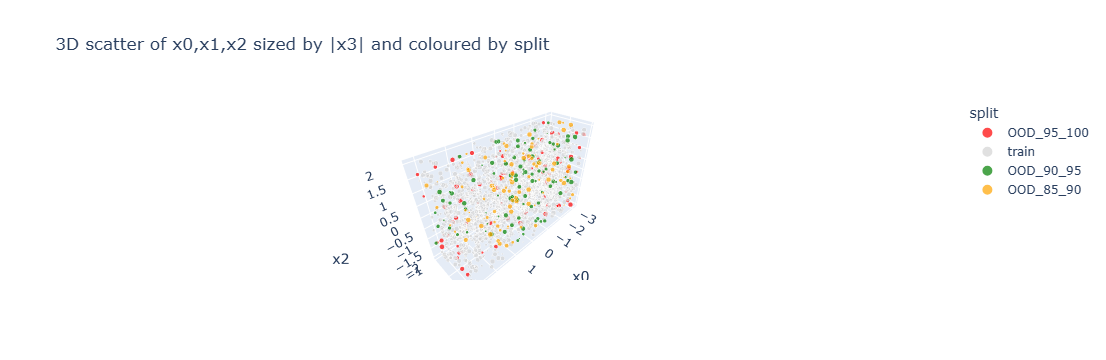

In [11]:
df['x3_abs'] = np.abs(df['x3'])
fig3d = px.scatter_3d(
  df,
  x='x0', y='x1', z='x2',
  color='split',
  size='x3_abs',
  size_max=8,
  color_discrete_map= {'train':'lightgray','OOD_85_90':'orange','OOD_90_95':'green','OOD_95_100':'red'},
  title='3D scatter of x0,x1,x2 sized by |x3| and coloured by split'
)
fig3d.show()

In [8]:
# 5) Train/evaluate loop
results = []
for split_name in ['OOD_95_100','OOD_90_95','OOD_85_90']:
    train_idx = df['split'] != split_name
    test_idx  = df['split'] == split_name

    X_train = df.loc[train_idx, ['x0','x1','x2','x3']]
    y_train = df.loc[train_idx, 'F']
    X_test  = df.loc[test_idx,  ['x0','x1','x2','x3']]
    y_test  = df.loc[test_idx,  'F']

    # replace with any black-box learner you like
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results.append({
        'split' : split_name,
        'n_test': test_idx.sum(),
        'MAE'    : mean_absolute_error(y_test, y_pred),
        'MSE'    : mean_squared_error(y_test, y_pred)
    })

# 6) Summarise
results_df = pd.DataFrame(results)
print(results_df)

        split  n_test       MAE       MSE
0  OOD_95_100     100  0.169370  0.091259
1   OOD_90_95     100  0.093474  0.018980
2   OOD_85_90     100  0.102195  0.023157


In [12]:
#random selection in
n_bins = 50
hist, bin_edges = np.histogram(y[df.split=='train'], bins=n_bins, density=True)
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])

p_random = hist / hist.sum()

# avoid division by zero
inv = 1.0/(hist + 1e-6)
p_inverted = inv / inv.sum()

# For F test points OOD region:
# sample bin indices according to each distribution:
idx_rand = np.random.choice(n_bins, size=len(y[df.split=='OOD test']), p=p_random)
idx_inv  = np.random.choice(n_bins, size=len(y[df.split=='OOD test']), p=p_inverted)

# map back to F values:
F_pred_random = bin_centers[idx_rand]
F_pred_inverted = bin_centers[idx_inv]

for name, split in [('random',F_pred_random), ('random inverted',F_pred_inverted)]:
    mse = mean_squared_error(y[df.split=='OOD test'], split)
    mae = mean_absolute_error(y[df.split=='OOD test'], split)
    print(f"{name:>8s}  MSE={mse:.4f}  MAE={mae:.4f}")


NameError: name 'y' is not defined

In [11]:
# 2. Train RandomForest on the *train* rows
# No known construction procedure of the OOD splits
RFmodel = RandomForestRegressor(n_estimators=100, random_state=21)
X = df[['x0','x1','x2','x3']]
y = df['F']
RFmodel.fit(X[df.split=='train'], y[df.split=='train'])

# 3. Predict & compute metrics on both splits
df['F_pred'] = RFmodel.predict(X)
metrics = {}
for split in ['train','OOD test']:
    y_true =  df.loc[df.split==split, 'F']
    y_pred =  df.loc[df.split==split, 'F_pred']
    metrics[split] = {
        'MSE': mean_squared_error(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred)
    }

print("Metrics by split:")
for split, m in metrics.items():
    print(f"  {split:8s}  MSE = {m['MSE']:.4f},  MAE = {m['MAE']:.4f}")

Metrics by split:
  train     MSE = 0.0097,  MAE = 0.0662
  OOD test  MSE = 0.4751,  MAE = 0.4645


In [28]:
# 2. Train RandomForest on the *train* rows
MLPmodel = MLPRegressor(hidden_layer_sizes=(100, 100),  # two hidden layers of 100 units each
    activation='relu',
    solver='adam',
    alpha=1e-4,  # L2 penalty
    learning_rate='constant',
    learning_rate_init=1e-3,
    max_iter=500,
    random_state=21,
)

MLPmodel.fit(X[df.split=='train'], y[df.split=='train'])

# 3. Predict & compute metrics on both splits
df['F_pred'] = MLPmodel.predict(X)
metrics = {}
for split in ['train','OOD test']:
    y_true =  df.loc[df.split==split, 'F']
    y_pred =  df.loc[df.split==split, 'F_pred']
    metrics[split] = {
        'MSE': mean_squared_error(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred)
    }

print("Metrics by split:")
for split, m in metrics.items():
    print(f"  {split:8s}  MSE = {m['MSE']:.4f},  MAE = {m['MAE']:.4f}")

Metrics by split:
  train     MSE = 0.0114,  MAE = 0.0691
  OOD test  MSE = 0.0632,  MAE = 0.1707


In [32]:
# 2. Train GradientBoosting on the *train* rows
GBRmodel = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3,random_state=21)

GBRmodel.fit(X[df.split=='train'], y[df.split=='train'])

# 3. Predict & compute metrics on both splits
df['F_pred'] = GBRmodel.predict(X)
metrics = {}
for split in ['train','OOD test']:
    y_true =  df.loc[df.split==split, 'F']
    y_pred =  df.loc[df.split==split, 'F_pred']
    metrics[split] = {
        'MSE': mean_squared_error(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred)
    }

print("Metrics by split:")
for split, m in metrics.items():
    print(f"  {split:8s}  MSE = {m['MSE']:.4f},  MAE = {m['MAE']:.4f}")

Metrics by split:
  train     MSE = 0.0486,  MAE = 0.1647
  OOD test  MSE = 0.2883,  MAE = 0.3881


In [ ]:

# Save and output path
html_path = 'C:/Users/hurst/anaconda_projects/OOD/F_visualisation.html'
fig.write_html(html_path, include_plotlyjs='cdn')

print(f"Interactive plot saved: sandbox:{html_path}")
